#### Preliminaries

##### Meeting I
- drift initial condition is not important as I divide by S, do the S_max derivation of Christoph
- set volatility = 0.1-0.4
- overhead for the calling of functions within python
- J-dimensional matrix multiplication in tensorflow 
- Block-diagonal problem in multidimension to call the function once, each block has a different volatility 

In [1331]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import sys
sys.path.insert(1, '/Users/filippo/Desktop/smoking_adjoints')
import importlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
torch.set_printoptions(precision = 8)
import matplotlib.pyplot as plt
import random
import time
from scipy import sparse
from scipy.sparse.linalg import spsolve
import pickle

In [1332]:
import Grid
import bs_pde.bs_pde_standard.bs_pde_standard
import function
import S_construction
import B_construction.B_construction_time_invariant_
importlib.reload(Grid)
importlib.reload(bs_pde.bs_pde_standard.bs_pde_standard)
importlib.reload(function)
importlib.reload(S_construction)
importlib.reload(B_construction.B_construction_time_invariant_)
from Grid import Grid
from bs_pde.bs_pde_standard.bs_pde_standard import Bs_pde_standard
from function import Function, Call, Put 
from S_construction import S_construction
from B_construction.B_construction_time_invariant_ import B_construction_time_invariant

In [1333]:
def european_call(S0,sigma,r,T,K,opt):
    #
    # Black-Scholes European call option solution
    # as defined in equation (3.17) on page 48 of 
    # The Mathematics of Financial Derivatives
    # by Wilmott, Howison and Dewynne
    #
    # r     - interest rate
    # sigma - volatility
    # T     - time to maturity 
    # S0     - asset value(s) at time 0
    # K     - strike price(s)
    # opt   - 'value', 'delta', 'gamma' or 'vega'
    # V     - option value(s)
    assert opt in {'value', 'delta', 'gamma', 'vega'}
    S0  = np.maximum(1e-100,S0);     # avoids problems with S0=0
    K  = np.maximum(1e-100,K);     # avoids problems with K=0

    d1 = ( np.log(S0) - np.log(K) + (r+0.5*sigma**2)*T ) / (sigma*np.sqrt(T))
    d2 = ( np.log(S0) - np.log(K) + (r-0.5*sigma**2)*T ) / (sigma*np.sqrt(T))

    if opt == 'value':
        V = S0*norm.cdf(d1) - np.exp(-r*T)*K*norm.cdf(d2)
    elif opt == 'delta':
        V = norm.cdf(d1)
    elif opt == 'gamma':
        V = exp(-0.5*d1**2) / (sigma*sqrt(2*pi*T)*S0);
    elif opt == 'vega':
        V = S0*(exp(-0.5*d1**2)/sqrt(2*pi))*( sqrt(T)-d1/sigma) - \
            np.exp(-r*T)*K*(exp(-0.5*d2**2)/sqrt(2*pi))*(-sqrt(T)-d2/sigma)   
    else:
        raise ValueError('invalid value for opt -- must be ''value'', ''delta'', ''gamma'', ''vega''')
        
    return V

In [1334]:
# def TDMAsolver(B, b):
#     """
#     Tri Diagonal Matrix Algorithm(a.k.a Thomas algorithm) solver for Bx=b
#     B is scipy.sparse.dia.dia_matrix pr scipy.sparse.csr.csr_matrix with three diagonals
#     refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
#     and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
#     """
#     low, centre, up = B.diagonal(-1).copy(), B.diagonal(0).copy(), B.diagonal(1).copy()
#     bc = b.copy() # copy array
#     d = len(b) # number of equations

#     for it in range(1, d):
#         temp       = low[it-1]/centre[it-1]
#         centre[it] = centre[it] - temp*up[it-1] 
#         bc[it]     = bc[it]     - temp*bc[it-1]
#     x = centre
#     x[-1] = bc[-1]/centre[-1]
    
#     for il in range(d-2, -1, -1):
#         x[il] = (bc[il]-up[il]*x[il+1])/centre[il]
#     return x

In [1335]:
class Grid_fde(Grid):
    def __init__(self, N, J, delta_S, delta_t, S):
        self.N = N
        self.J = J
        self.delta_S = delta_S
        self.delta_t = delta_t
        self.S = S

def create_grid(J, Smax, T, grid_type):
    if grid_type == "linear":
        # Keeps ratio N/J fixed, i.e. dt/dx 
        N = J
    elif grid_type == "quadratic":
        N = J**2    
    elif grid_type == "constant":
        N = 16
    S = np.linspace(0,Smax,J+1)
    dS = Smax/J
    dt = T/N
    grid = Grid_fde(N, J, dS, dt, S)
    return grid
    
    
def bs_matrix(grid, sigma, r):
    d = len(grid.S)
    b_construction_time_invariant = B_construction_time_invariant(grid.S, sigma, r, grid.delta_t, grid.delta_S)
    B = b_construction_time_invariant.evaluate()
    return sparse.identity(d) - B

def bs_pde_theta_scheme(theta, option, grid, sigma, r):
    # theta is the proportion of implicit scheme
    assert 0 <= theta and theta <= 1
    
    d = len(grid.S)
    bs_mat = bs_matrix(grid, sigma, r)
    B_exp  = sparse.identity(d) - (1-theta) * bs_mat
    B_imp  = sparse.identity(d) + theta     * bs_mat
    f = option.evaluate(grid.S)
    u = np.copy(f)
    for n in reversed(range(grid.N)):
        u = B_exp.dot(u)
#         u = TDMAsolver(B_imp, u)
        u = spsolve(B_imp, u) # is as fast (if not slightly faster) as the Thomas solver
    return u


# def bs_pde_explicit(option, grid, sigma, r):
#     b_construction_time_invariant = B_construction_time_invariant(grid.S, sigma, r, grid.delta_t, grid.delta_S)
#     B = b_construction_time_invariant.evaluate()
#     f = option.evaluate(grid.S)
#     u = np.copy(f)
#     for n in reversed(range(grid.N)):
#         u = B.dot(u)
#     return u

def fde_volatility(sigmas: np.array, 
                   theta: float, 
                   option: Function,
                   grid: Grid_fde,
                   S0: float,
                   r: float):
    call_approximation = np.zeros(len(sigmas))
    for i in range(len(sigmas)):
#       if i % 10000 == 0:
#          print(i+1)
        u_fde = bs_pde_theta_scheme(theta, option, grid, sigmas[i], r)
        call_approximation[i] = u_fde[np.where(grid.S==S0)[0][0]]
    return call_approximation


def create_training_set_volatility(train_size: int, 
                                   theta: float, 
                                   option: Function, 
                                   grid: Grid_fde,
                                   S0: float,
                                   max_sigma: float, 
                                   min_sigma: float, 
                                   r: float,
                                   train_to_val_ratio : float = float("inf")):
    sigmas = np.linspace(min_sigma, max_sigma, train_size + 1)
    call_approximation = fde_volatility(sigmas, theta, option, grid, S0, r)
        
    if train_to_val_ratio == float("inf"):
        return sigmas, call_approximation
    else:
        dSigma = sigmas[1] - sigmas[0]
        sigmas_val = sigmas + dSigma/2
        assert train_size % train_to_val_ratio == 0, "The train size is not divisible by the ratio of train size to validation size"
        sigmas_val = np.array([sigmas_val[idx] for idx in range(len(sigmas)-1) if idx % train_to_val_ratio == 0])
#       sigmas_val = np.random.choice(sigmas_val, int(len(sigmas) * val_set_ratio))
        call_approximation_val = fde_volatility(sigmas_val, theta, option, grid, S0, r)
        return sigmas, call_approximation, sigmas_val, call_approximation_val

def create_testing_set_volatility_call(test_size: int,
                             max_sigma: float,
                             min_sigma: float,
                             S0: np.ndarray,
                             K: float, 
                             r: float):
    sigmas = np.linspace(min_sigma, max_sigma, test_size + 1)
    call_true = european_call(S0,sigmas,r,T,K,"value")
    return sigmas, call_true

In [1336]:
# To Do
# def bs_matrix_ext(grid, sigma, r):
#     """
#     sigma is a numpy vector
#     """
#     # I need to change B construction etc ... as to output a sparse huge matrix, with block triagonals ....
#     d = len(grid.S)*len(sigma)
#     b_construction_time_invariant = B_construction_time_invariant(grid.S, sigma, r, grid.delta_t, grid.delta_S)
#     B = b_construction_time_invariant.evaluate()
#     return sparse.identity(d) - B


In [1337]:
def err(x, y_app, y_true, error_type):
    dX = float(x[1]-x[0]) # assume equally spaced testing set
    if error_type == "l_2":
        err = np.linalg.norm(y_app-y_true)*np.sqrt(dX)
    elif error_type == "l_inf":
        err = np.linalg.norm(y_app-y_true, ord = float("inf"))
    else:
        raise ValueError("No valid error type")
    return err

def compute_error(x_c, y_c, x_f, y_f):
    """
    The values of x_c, y_c are on the coarser grid and the values x_f and y_f are on the finer grid. 
    We assume that the grid lengths are multiple of each other and that the coarse data have more data points. 
    """
    idxStart = np.where(np.isclose(x_c, x_f[0], atol=1e-16))[0][0]
    idxLast = np.where(np.isclose(x_c, x_f[-1], atol=1e-16))[0][0]
    x_c = x_c[idxStart:idxLast+1]
    y_c = y_c[idxStart:idxLast+1]
    train_size_c = len(x_c) - 1
    train_size_f = len(x_f) - 1
    assert train_size_c % train_size_f == 0
    ratio = train_size_c // train_size_f
    indeces_c = [idx*ratio for idx in range(len(x_f))]
    x_c_new = [x_c[idx] for idx in indeces_c]
    assert np.allclose(x_c_new, x_f, atol = 1e-16), "We pick up the wrong grid points in the coarser grid."
    y_c = [y_c[idx] for idx in indeces_c]
    err = y_f - y_c
    return err 

In [1338]:
def RoundNearestMultiple(x, multiple):
    assert x >= 0 and multiple > 0
#     if multiple == 0:
#         return x
    remainder = x % multiple
    if remainder <= x/2:
        return x - remainder
    else:
        return x + multiple - remainder 
    

#### Input parameters

In [1339]:
#input parameters
S0 = 1
K = 0.99 # slightly misaligned with S0
Smax = 2.5
T = 1
r = 0.1
sigma = 0.2
J = 5*2**4

theta = 0.5

call = Call(K)
grid = create_grid(J, Smax, T, "linear")

In [1340]:
max_sigma = 0.4
min_sigma = 0.1
train_size_exponential = 4
train_size = 2**(2*train_size_exponential)
train_to_val_ratio = 4

L_input = 2 # we use in total 2*L+1 levels
L = list(range(-L_input,L_input+1))
train_size_L = np.array([int(round(train_size/2**(2*l))) for l in L])
# train_size_L = (np.array([488880,   1680,    240,     40,     20])).astype(int)
# train_size_L = (l2_list/l2_list[L_input] * train_size).astype(int) # does NOT preserve simialar computational time across levels
# for i in reversed(range(len(train_size_L)-1)):
#     train_size_L[i] = RoundNearestMultiple(train_size_L[i], train_size_L[i+1])
# train_size_L[0] = train_size_L[0] * 2**(2*L[-1])
J_L = np.array([int(2**l*J) for l in L])


# BS PDE - theta scheme

In [1341]:
%%time
u_fde = bs_pde_theta_scheme(theta, call, grid, sigma, r)
# u_fde = bs_pde_explicit(call, grid, sigma, r)

CPU times: user 13.5 ms, sys: 4.32 ms, total: 17.8 ms
Wall time: 17.8 ms


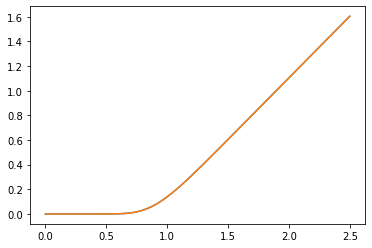

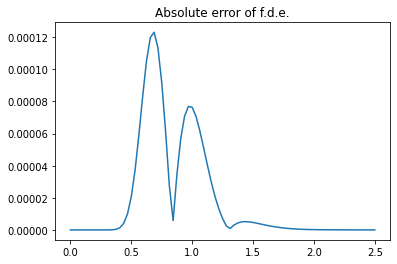

(5.994488918625087e-05, 0.00012310592788820733)

In [1342]:
u_true = european_call(grid.S, sigma, r, T, K, "value")
plt.plot(grid.S, u_true)
plt.plot(grid.S, u_fde)
plt.show()

plt.plot(grid.S, abs(u_true-u_fde));
plt.title("Absolute error of f.d.e.");
plt.show()

err_l2 = np.linalg.norm(u_fde-u_true)*np.sqrt(grid.delta_S)
err_inf = np.linalg.norm(u_fde-u_true, ord = float("inf"))
err_l2, err_inf

In [1343]:
l2_err_list = []
Js = np.array([5*2**k for k in  range(7)])

for J_loop in Js:
    print(J_loop)
    grid_loop = create_grid(J_loop, Smax, T, "linear")
    call_approximation = bs_pde_theta_scheme(theta, call, grid_loop, sigma, r)
    call_true = european_call(grid_loop.S, sigma, r, T, K, "value")
    l2_err = err(grid_loop.S, call_approximation, call_true, "l_2")
    l2_err_list.append(l2_err)

5
10
20
40
80
160
320


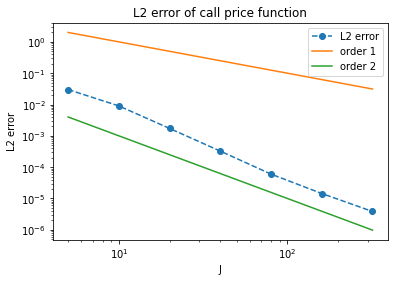

In [1344]:
order_1 = 10/Js
order_2 = 0.1/Js**2
plt.loglog(Js, l2_err_list, "--o", label = "L2 error")
plt.loglog(Js, order_1, label = "order 1")
plt.loglog(Js, order_2, label = "order 2")
plt.title("L2 error of call price function")
plt.xlabel("J")
plt.ylabel("L2 error")
plt.legend()
plt.savefig("plots_neural_pde/l2_error_call_price.png")
plt.show()

In [1345]:
%%time
l2_err_list = []
Js = np.array([5*2**k for k in  range(7)])
train_size_cvg = 64
sigmas = np.linspace(min_sigma, max_sigma, train_size_cvg + 1)
call_true = european_call(S0, sigmas, r, T, K, "value")

for J_loop in Js:
    print("nbr samples:", train_size_cvg, "J:", J_loop)
    grid_loop = create_grid(J_loop, Smax, T, "linear")
    sigmas, call_approximation = create_training_set_volatility(train_size_cvg, theta, call, grid_loop, S0, max_sigma, min_sigma, r)
    l2_err = err(sigmas, call_approximation, call_true, "l_2")
    l2_err_list.append(l2_err)

nbr samples: 64 J: 5
nbr samples: 64 J: 10
nbr samples: 64 J: 20
nbr samples: 64 J: 40
nbr samples: 64 J: 80
nbr samples: 64 J: 160
nbr samples: 64 J: 320
CPU times: user 6.34 s, sys: 402 ms, total: 6.74 s
Wall time: 6.93 s


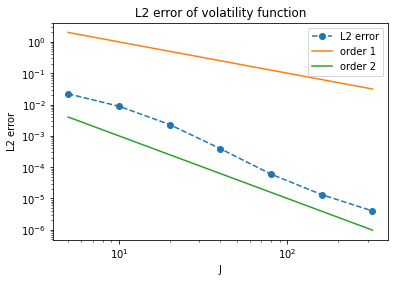

In [1346]:
order_1 = 10/Js
order_2 = 0.1/Js**2
plt.loglog(Js, l2_err_list, "--o", label = "L2 error")
plt.loglog(Js, order_1, label = "order 1")
plt.loglog(Js, order_2, label = "order 2")
plt.title("L2 error of volatility function")
plt.xlabel("J")
plt.ylabel("L2 error")
plt.legend()
plt.savefig("plots_neural_pde/l2_error_vol_function.png")
plt.show()

# Data generation

In [1347]:
%%time
x_train_standard_size = len(L)*train_size
print("nbr samples:", x_train_standard_size, "J:", grid.J, "sigma:", min_sigma, "-", max_sigma)
x_train_standard, y_train_standard, x_val_standard, y_val_standard = create_training_set_volatility(x_train_standard_size, theta, call, grid, S0, max_sigma, min_sigma, r, train_to_val_ratio)

nbr samples: 1280 J: 80 sigma: 0.1 - 0.4
CPU times: user 14.4 s, sys: 1.08 s, total: 15.5 s
Wall time: 15.8 s


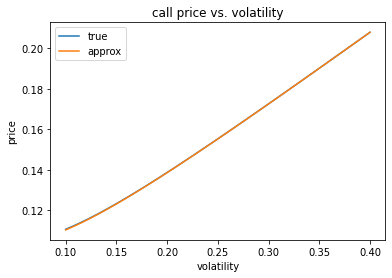

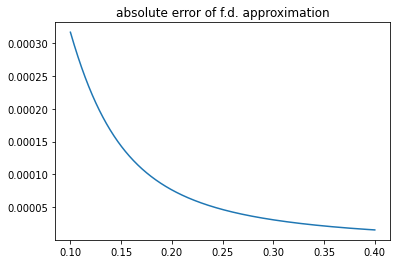

L2 err: 5.7823677887354653e-05 L_inf err: 0.00031669413583927664


In [1348]:
y_train_true_standard = european_call(S0,x_train_standard,r,T,K,"value")
plt.plot(x_train_standard, y_train_true_standard, label = "true")
plt.plot(x_train_standard, y_train_standard, label = "approx")
# plt.axvline(np.sqrt(grid.delta_S * r), label = "stability condition", color = "g")
plt.xlabel("volatility")
plt.ylabel("price")
plt.title("call price vs. volatility")

plt.legend()
plt.show()

plt.plot(x_train_standard, abs(y_train_true_standard - y_train_standard))
plt.title("absolute error of f.d. approximation")
plt.show()

err_l2 = err(x_train_standard, y_train_standard, y_train_true_standard, "l_2")
err_inf = err(x_train_standard, y_train_standard, y_train_true_standard, "l_inf")

# dSigma = x_train_standard[1] - x_train_standard[0]
# err_l2 = np.linalg.norm(y_train_standard-y_train_true_standard)*np.sqrt(dSigma)
# err_inf = np.linalg.norm(y_train_standard-y_train_true_standard, ord = float("inf"))*np.sqrt(dSigma)
print("L2 err:", err_l2, "L_inf err:", err_inf)

In [1349]:
%%time
# multilevel approaches
# times = []
set_multigrid = []
set_multilevel = []
# err_train_mean_list = []
# err_train_std_list = []

for i,l in enumerate(L):
    print("l:", l)
#     start_time = time.time()
    train_size_l = train_size_L[i]
    J_l = J_L[i]
    grid_loop = create_grid(J_l, Smax, T, "linear")
    print("nbr train samples:",  train_size_l, "nbr val samples:", train_size_l // train_to_val_ratio, "J:", grid_loop.J)
    x_train, y_train, x_val, y_val = create_training_set_volatility(train_size_l, 
                                                                    theta, 
                                                                    call, 
                                                                    grid_loop, 
                                                                    S0, 
                                                                    max_sigma, 
                                                                    min_sigma, 
                                                                    r, 
                                                                    train_to_val_ratio)

    # create error samples for multilevel approach
    if i==0:
        err_train = y_train
        err_val = y_val
    else:
        x_train_coarse, y_train_coarse, _, _ = set_multigrid[i-1]
#         train_size_lm1 = train_size_L[i-1]
#         ratio = train_size_lm1 // train_size_l
#         assert train_size_lm1 % train_size_l == 0, "Train size at level l-1 is not a multiple of the train size at level l."
#         indeces_coarse = [idx*ratio for idx in range(len(x_train))]
#         x_train_coarse = [x_train_coarse[idx] for idx in indeces_coarse]
#         assert np.allclose(x_train_coarse, x_train, atol = 1e-16), "We pick up the wrong grid points in the coarser grid."
#         y_train_coarse = [y_train_coarse[idx] for idx in indeces_coarse]
#         err_train = y_train - y_train_coarse
        err_train = compute_error(x_train_coarse, y_train_coarse, x_train, y_train)        
        err_val = compute_error(x_train_coarse, y_train_coarse, x_val, y_val)
    set_multigrid.append((x_train, y_train, x_val, y_val))
    set_multilevel.append((x_train, err_train, x_val, err_val))
#     end_time = time.time()
#     times.append(end_time-start_time)

l: -2
nbr train samples: 4096 nbr val samples: 1024 J: 20
l: -1
nbr train samples: 1024 nbr val samples: 256 J: 40
l: 0
nbr train samples: 256 nbr val samples: 64 J: 80
l: 1
nbr train samples: 64 nbr val samples: 16 J: 160
l: 2
nbr train samples: 16 nbr val samples: 4 J: 320
CPU times: user 25.9 s, sys: 1.54 s, total: 27.5 s
Wall time: 27.9 s


Note that as I increase the number of J, for example: J = 40, then the ratio of the computational cost for the generation of samples stays 2 to 1 (more computational costly to generate multilevel samples).

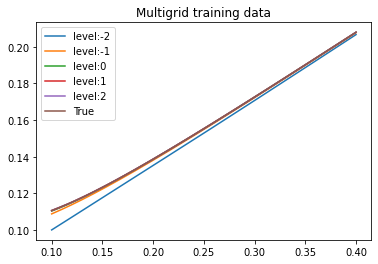

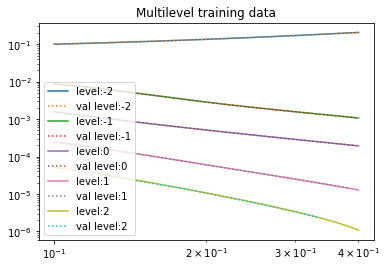

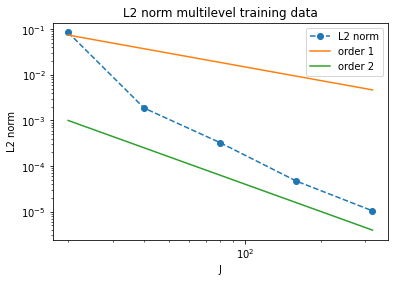

In [1442]:
l2_err_list = []
l2_list = []
abs_err_list = []
for i,l in enumerate(L):
    x_train, y_train, x_val, y_val = set_multigrid[i]
    y_true = european_call(S0,x_train,r,T,K,"value")
    l2_err_list.append(err(x_train, y_train, y_true, "l_2"))
#     abs_err_list.append(abs(y_true - y_train))
    plt.plot(x_train, y_train, label = "level:" + str(l))
plt.plot(x_train_standard, european_call(S0, x_train_standard, r, T, K, "value"), label = "True")
plt.title("Multigrid training data")
plt.legend()
plt.show()

# for i,l in enumerate(L):
#     plt.plot(set_multigrid[i][0], abs_err_list[i], label = "level:" + str(l))
# plt.legend()
# plt.show()

# order_1 = 0.4/Js
# order_2 = 0.2/Js**2
# plt.loglog(J_L, l2_err_list, "--o" , label = "L2 error")
# plt.loglog(J_L, order_1, label = "order 1")
# plt.loglog(J_L, order_2, label = "order 2")
# plt.title("L2 error of volatility function")
# plt.xlabel("J")
# plt.ylabel("L2 error")
# plt.legend()
# plt.savefig("plots_neural_pde/l2_error_vol_function_training_set.png")
# plt.show()

for i, l in enumerate(L):
    x_train, y_train, x_val, y_val = set_multilevel[i]
    l2 = err(x_train, y_train, np.zeros(len(x_train)), "l_2")
    l2_list.append(l2)
    plt.loglog(x_train, y_train, label = "level:" + str(l))
    plt.loglog(x_val, y_val, linestyle = "dotted" , label = "val level:" + str(l))
plt.title("Multilevel training data")
plt.legend()
plt.show()


order_1 = 1.5/J_L
order_2 = 0.4/J_L**2
plt.loglog(J_L, l2_list, "--o" , label = "L2 norm")
plt.loglog(J_L, order_1, label = "order 1")
plt.loglog(J_L, order_2, label = "order 2")
plt.title("L2 norm multilevel training data")
plt.xlabel("J")
plt.ylabel("L2 norm")
plt.legend()
plt.savefig("plots_neural_pde/l2_norm_multilevel_training_data.png")
plt.show()

    

In [1375]:
test_size = 8000
x_test, y_test = create_testing_set_volatility_call(test_size, max_sigma, min_sigma, S0, K, r)

In [1376]:
with open("set_standard.pickle", "wb") as f:
    pickle.dump((x_train_standard, y_train_standard, x_val_standard, y_val_standard), f)

with open("set_multigrid.pickle", "wb") as f:
    pickle.dump(set_multigrid, f)
    
with open("set_multilevel.pickle", "wb") as f:
    pickle.dump(set_multilevel, f)
    
with open("set_test.pickle", "wb") as f:
    pickle.dump((x_test, y_test), f)

# NN Standard approach

In [1279]:
class Network(nn.Module):
    def __init__(self, dim, H, mean_std_tuple = None):
        super().__init__()
        self.fc1 = nn.Linear(dim, H)
        self.fc2 = nn.Linear(H, 1)
        self.activation_function = nn.ReLU() # nn.Sigmoid() 
        self.mean_std_tuple = mean_std_tuple
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation_function(x)
        x = self.fc2(x)
        return x
    
    def evaluate_original(self, x):
        """
        Assumes that the NN has been trained on normalized data
        input: normalized data x_norm
        output: convert the normalized output back to the original scale
        """
        assert self.mean_std_tuple is not None
        mean, std = self.mean_std_tuple
        return self.forward(x) * std + mean

In [1545]:
class Multilevel_nn:
    def __init__(self, model_multilevel_list: list):
#         assert len(model_multilevel_list) == len(y_mean_list) and len(y_mean_list) == len(y_std_list)
        self.model_multilevel_list = model_multilevel_list
    
    def __call__(self, x):
        res = 0
        for model in self.model_multilevel_list:
            res += model(x)
        return res
        
    def evaluate_original(self, x):
        res = 0
        for model in self.model_multilevel_list:
            res += model.evaluate_original(x)
        return res

In [1532]:
# testing 
def test_nn(model, x_test, y_test, same_scale, visualize = False, y_val = np.array([])):
    """
    The variable "same_scale" determines whether the NN output is trained on the same scale as y_test.
    """
    x_test = torch.reshape(torch.Tensor(x_test), (len(x_test), 1))
    y_nn = model(x_test) if same_scale else model.evaluate_original(x_test)
    y_nn = y_nn.squeeze(dim=1).detach().numpy()
    
    err_l2 = err(x_test, y_nn, y_test, "l_2")
    err_inf = err(x_test, y_nn, y_test, "l_inf")
    
    if visualize:
        plt.plot(x_test, y_test, label = "true")
        if y_val.size != 0:
            plt.plot(x_test, y_val, linewidth=1, label = "f.d.e. approx")
        plt.plot(x_test, y_nn, linewidth=1, label = "nn approx")
        plt.xlabel("volatility")
        plt.ylabel("price")
        plt.title("call price vs. volatility")
        plt.legend()
        plt.show()
        
        if y_val.size != 0:
            plt.plot(x_test, abs(y_val - y_nn), label = "approximation error")
            plt.plot(x_test, abs(y_test - y_val), label = "discretization error")
        else:
            plt.plot(x_test, abs(y_test - y_nn), label = "absolute error nn approx to true price")
        plt.xlabel("volatility")
        plt.ylabel("absolute error")
        plt.title("absolute error")
        plt.legend()
        plt.show()

    return err_l2, err_inf


In [1563]:
def train_nn(model, 
             x_train, 
             y_train, 
             batch_size, 
             num_epochs, 
             lr,
             with_validation = False,
             x_val = np.array([]), 
             y_val = np.array([]),
             err_val_l2_list = [],
             err_val_inf_list = [],
             with_test_error = False,  
             x_test = np.array([]), 
             y_test = np.array([]),
             same_scale = False,
             error_test_l2_list = [], 
             error_test_inf_list = [],
             early_stopping_steps = None,
             model_multilevel_list = []):
    assert not (with_validation == False and early_stopping_steps is not None), "No early stopping without validation set"
    dX = x_train[1] - x_train[0] # assume equally spaced grid
    optimizer = optim.SGD(model.parameters(), lr=lr) # Use stochastic gradient descent
    model.train()
    for epoch in range(num_epochs):
        train_size = len(x_train)
        I_permutation = np.random.permutation(train_size)
        x_train = torch.Tensor(x_train[I_permutation])
        x_train = torch.reshape(x_train, (train_size, 1))
        y_train = torch.Tensor(y_train[I_permutation])
        epoch_loss = []
        for i in range(0,train_size, batch_size):
            x_train_batch = x_train[i:i+batch_size,:]
            y_train_batch = y_train[i:i+batch_size]
            data, target = Variable(x_train_batch), Variable(y_train_batch)
            optimizer.zero_grad()
            output = model(data).squeeze(dim=1)
            loss = F.mse_loss(output, target)
            epoch_loss.append(float(loss))
            loss.backward()
            optimizer.step() # update parameters
        if model_multilevel_list:
            model_epoch = Multilevel_nn(model_multilevel_list + [model])
        else:
            model_epoch = model
        if with_test_error:
            err_test_l2, err_test_inf = test_nn(model_epoch, x_test, y_test, same_scale)
            error_test_l2_list.append(err_test_l2)
            error_test_inf_list.append(err_test_inf)
        if with_validation:
            err_val_l2, err_val_inf = test_nn(model, x_val, y_val, same_scale = True) # Assume that y_train and y_val are on the same scale 
            err_val_l2_list.append(err_val_l2)
            err_val_inf_list.append(err_val_inf)
            if early_stopping_steps and epoch > early_stopping_steps:
                min_last_steps = min(err_val_l2_list[-early_stopping_steps:])
                if min_last_steps == err_val_l2_list[-early_stopping_steps]:
                    break
        if epoch % 100 == 0:
            epoch_loss_rmse = np.sqrt(np.array(epoch_loss) * dX).mean()
            _, std_model = model.mean_std_tuple
            err_val_l2_norm = err_val_l2 * std_model
            if with_validation:
                print("epoch:", "{:<5}".format(epoch), "loss:", "{:.3e}".format(epoch_loss_rmse) , "validation loss:", "{:.3e}".format(err_val_l2),
                     "normalized validation loss:", "{:.3e}".format(err_val_l2_norm))
            else:
                print("epoch:", epoch, "loss:", "{:.3e}".format(epoch_loss_rmse))
            

In [ ]:
def normalize_data(y, mean_std_tuple = None):
    """
    Normalize y beased on the provided tuple of mean and standard deviation.
    If this tuple is not provided, compute it and output it.
    """
    mean, std = (y.mean(), y.std()) if mean_std_tuple is None else mean_std_tuple
    y -= mean
    y /= std
    if mean_std_tuple is None:
        return mean, std
    else:
        return 

In [1547]:
# input parameters

with open("set_multigrid.pickle", "rb") as f:
    set_multigrid = pickle.load(f)

with open("set_multilevel.pickle", "rb") as f:
    set_multilevel = pickle.load(f)
    
with open("set_standard.pickle", "rb") as f: 
    x_train_standard, y_train_standard, x_val_standard, y_val_standard = pickle.load(f)

with open("set_test.pickle", "rb") as f:
    x_test, y_test = pickle.load(f)
    
dim = 1
lr = 0.02 # no lr_L

const_H = 4
# H = 2**7
H = int(np.sqrt(train_size_L.sum()/np.log(train_size_L.sum())))*const_H
H_L = H * np.ones(len(L), dtype = int)
# H_L = np.sqrt(train_size_L/np.log(train_size_L)).astype(int)*const_H #choose N/logN is proportional to n^2 with N = #samples, n = #nodes

early_stopping_steps = 200

max_batch_size = 32
batch_size = min(train_size, max_batch_size)
batch_size_L = np.minimum(train_size_L+1, max_batch_size)

num_epochs = train_size * 50
num_epochs_L = (np.ones(len(L)) * num_epochs // len(L)).astype(int) * 5
# num_epochs_L = np.array([int(train_size_L[i]* num_epochs/train_size) for i in reversed(range(len(L)))])
# num_epochs_L = num_epochs_L * 2**np.array(list(reversed(range(len(L)))))

In [1513]:
%%time
# one-dimensional case
val_error_l2_standard = []
val_error_inf_standard = []
test_error_l2_standard = []
test_error_inf_standard = []

y_train, y_val = copy.deepcopy(y_train_standard), copy.deepcopy(y_val_standard)
mean_std_tuple = normalize_data(y_train) # normalize training y
normalize_data(y_val, mean_std_tuple) # normalize validation y

model_standard = Network(dim, H, mean_std_tuple)
num_epochs_standard = num_epochs 

print("train_size:", len(x_train_standard), "H:", H, "batch_size:", batch_size, "nbr epochs:", num_epochs_standard)

train_nn(model_standard,
        x_train_standard, 
        y_train, 
        batch_size, 
        num_epochs_standard, 
        lr, 
        with_validation = True, 
        x_val = x_val_standard, 
        y_val = y_val,
        err_val_l2_list = val_error_l2_standard,
        err_val_inf_list = val_error_inf_standard,
        with_test_error = True, 
        x_test = x_test, 
        y_test = y_test_true, 
        same_scale = False,
        error_test_l2_list = test_error_l2_standard, 
        error_test_inf_list = test_error_inf_standard,
        early_stopping_steps = early_stopping_steps)

train_size: 1281 H: 100 batch_size: 30 nbr epochs: 12800
epoch: 0     loss: 1.420e-02 validation loss: 4.693e-01
epoch: 100   loss: 1.949e-04 validation loss: 7.451e-03
epoch: 200   loss: 1.725e-04 validation loss: 6.402e-03
epoch: 300   loss: 1.569e-04 validation loss: 5.810e-03
epoch: 400   loss: 1.460e-04 validation loss: 5.794e-03
epoch: 500   loss: 1.358e-04 validation loss: 5.098e-03
epoch: 600   loss: 1.290e-04 validation loss: 4.760e-03
epoch: 700   loss: 1.217e-04 validation loss: 4.531e-03
epoch: 800   loss: 1.153e-04 validation loss: 4.331e-03
epoch: 900   loss: 1.122e-04 validation loss: 4.112e-03
epoch: 1000  loss: 1.059e-04 validation loss: 3.973e-03
epoch: 1100  loss: 1.019e-04 validation loss: 3.847e-03
epoch: 1200  loss: 9.928e-05 validation loss: 3.679e-03
epoch: 1300  loss: 9.590e-05 validation loss: 3.636e-03
epoch: 1400  loss: 9.303e-05 validation loss: 3.497e-03
epoch: 1500  loss: 9.004e-05 validation loss: 3.424e-03
epoch: 1600  loss: 8.842e-05 validation loss: 3

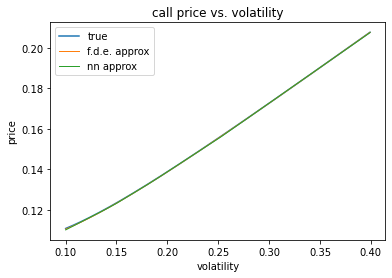

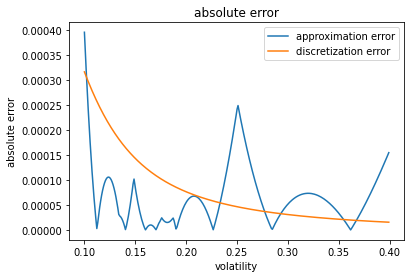

(8.319882518795529e-05, 0.0007114116551814043)

In [1514]:
y_test_val = european_call(S0,x_val_standard,r,T,K,"value")
test_nn(model_standard, x_val_standard, y_test_val, same_scale = False, visualize = True, y_val = y_val_standard)

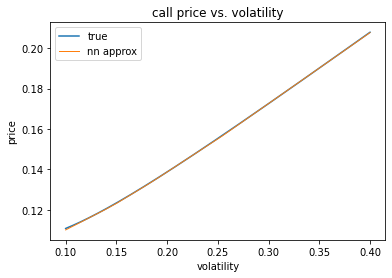

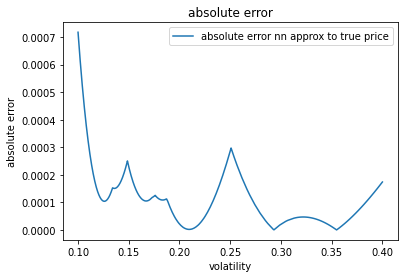

(8.221704788422517e-05, 0.0007174129975455745)

In [1515]:
test_nn(model_standard, x_test, y_test, same_scale = False, visualize = True)

## Full-multi grid approach

**Observation:** Note that the f.d.e. grid has in total J^3 grid points. Hence, the computational cost scales as J**3. In other words, for the same computational cost, we can compute x samples at J or x/2^3 samples at 2J. 

**Approach:** Each level uses an equal amount of computational cost for the data creation (NOT for the training of the NN!)

In [1516]:
%%time
test_error_l2_multigrid = []
test_error_inf_multigrid = []
val_error_l2_multigrid = []
val_error_inf_multigrid = []

for i,l in enumerate(L):
    x_train, y_train, x_val, y_val = copy.deepcopy(set_multigrid[i])
    if i == 0:
        mean_std_tuple = normalize_data(y_train) # normalize training y
        normalize_data(y_val, mean_std_tuple)
        model_multigrid = Network(dim, H, mean_std_tuple)
    else:
        normalize_data(y_train, model_multigrid.mean_std_tuple) # normalize data with the level 0 mean and std 
        normalize_data(y_val, model_multigrid.mean_std_tuple)

#         optimizer = optim.SGD(model_multigrid.parameters(), lr=lr)
    batch_size_l = batch_size_L[i]
    num_epochs_l = num_epochs_L[i]
    print("L:", l, "train_size:", len(x_train), "H:", H, "batch_size:", batch_size, "nbr epochs:", num_epochs_l)
    train_nn(model_multigrid,
             x_train, 
             y_train, 
             batch_size_l, 
             num_epochs_l, 
             lr,
             with_validation = True,
             x_val = x_val,
             y_val = y_val,
             err_val_l2_list = val_error_l2_multigrid,
             err_val_inf_list = val_error_inf_multigrid,
             with_test_error = True,
             x_test = x_test,
             y_test = y_test,
             same_scale = False,
             error_test_l2_list = test_error_l2_multigrid,
             error_test_inf_list = test_error_inf_multigrid,
             early_stopping_steps = early_stopping_steps)

L: -2 train_size: 4097 H: 100 batch_size: 30 nbr epochs: 12800
epoch: 0     loss: 6.129e-03 validation loss: 2.575e-01
epoch: 100   loss: 3.038e-05 validation loss: 1.997e-03
epoch: 200   loss: 1.292e-05 validation loss: 8.439e-04
epoch: 300   loss: 8.750e-06 validation loss: 5.877e-04
epoch: 400   loss: 7.303e-06 validation loss: 4.632e-04
epoch: 500   loss: 6.499e-06 validation loss: 4.231e-04
epoch: 600   loss: 6.003e-06 validation loss: 3.932e-04
epoch: 700   loss: 5.762e-06 validation loss: 3.654e-04
epoch: 800   loss: 5.557e-06 validation loss: 3.560e-04
epoch: 900   loss: 5.462e-06 validation loss: 3.750e-04
epoch: 1000  loss: 5.382e-06 validation loss: 3.412e-04
epoch: 1100  loss: 5.299e-06 validation loss: 3.377e-04
epoch: 1200  loss: 5.234e-06 validation loss: 3.424e-04
epoch: 1300  loss: 5.221e-06 validation loss: 3.287e-04
epoch: 1400  loss: 5.152e-06 validation loss: 3.523e-04
epoch: 1500  loss: 5.092e-06 validation loss: 3.276e-04
epoch: 1600  loss: 5.061e-06 validation l

**Observations:** 
1. The mean squared error of epochs with smaller batch sizes is not comparable to bigger batch sizes because the mse increases as the batch size increases.
2. Below, it does NOT work to take any other validation level than the finest, since the approximation error will contain the discretization error removed in the finer levels

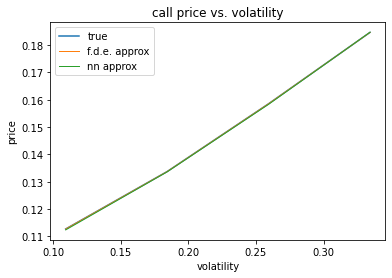

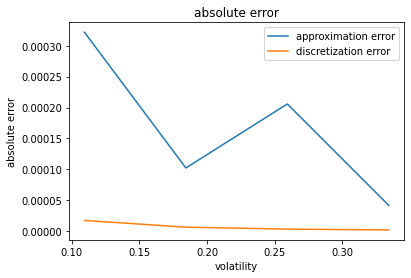

(0.00011359772181566382, 0.00033908209558763946)

In [1542]:
_, _, x_val, y_val = set_multigrid[-1]
y_test_val = european_call(S0,x_val,r,T,K,"value")
test_nn(model_standard, x_val, y_test_val, same_scale = False, visualize = True, y_val = y_val)

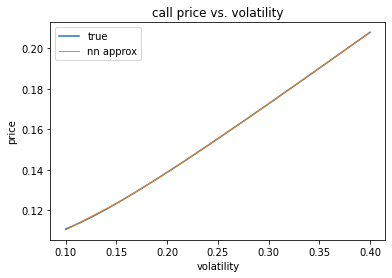

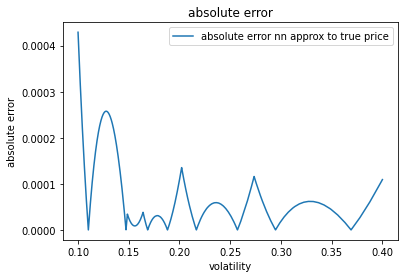

(5.008719881481525e-05, 0.00042897867089686237)

In [1517]:
test_nn(model_multigrid, x_test, y_test, same_scale = False, visualize = True)

## Multilevel approach

In [1564]:
%%time 
model_multilevel_list = []
test_error_l2_multilevel = []
test_error_inf_multilevel = []
val_error_l2_multilevel = []
val_error_inf_multilevel = []

# set_multilevel_train_coarse = []
for i,l in enumerate(L):
    batch_size_l = batch_size_L[i]
    num_epochs_l = num_epochs_L[i] // 100
    H_l = H_L[i]
    x_train, y_train, x_val, y_val = copy.deepcopy(set_multilevel[i])
    mean_std_tuple = normalize_data(y_train)
    normalize_data(y_val, mean_std_tuple)
    model_multilevel = Network(dim, H_l, mean_std_tuple)
#     if i > 1:
#         model_multilevel.load_state_dict(model_multilevel_list[-1].state_dict()) # initialize as the previous error neural network
    print("l:", l, "H:", H_l, "train size:", len(x_train), "batch size:", batch_size_l, "nbr epochs:", num_epochs_l)
    train_nn(model_multilevel,
         x_train, 
         y_train, 
         batch_size_l, 
         num_epochs_l, 
         lr,
         with_validation = True,
         x_val = x_val,
         y_val = y_val,
         err_val_l2_list = val_error_l2_multilevel,
         err_val_inf_list = val_error_inf_multilevel,
         with_test_error = True,
         x_test = x_test,
         y_test = y_test,
         same_scale = False,
         error_test_l2_list = test_error_l2_multilevel,
         error_test_inf_list = test_error_inf_multilevel,
         early_stopping_steps = early_stopping_steps,
         model_multilevel_list = model_multilevel_list)
    model_multilevel_list.append(model_multilevel)

l: -2 H: 100 train size: 4097 batch size: 30 nbr epochs: 128
epoch: 0     loss: 6.171e-03 validation loss: 2.580e-01 normalized validation loss: 7.932e-03
epoch: 100   loss: 2.517e-05 validation loss: 1.759e-03 normalized validation loss: 5.407e-05
l: -1 H: 100 train size: 1025 batch size: 30 nbr epochs: 128
epoch: 0     loss: 1.597e-02 validation loss: 4.935e-01 normalized validation loss: 9.434e-04
epoch: 100   loss: 4.733e-03 validation loss: 1.695e-01 normalized validation loss: 3.241e-04
l: 0 H: 100 train size: 257 batch size: 30 nbr epochs: 128
epoch: 0     loss: 3.254e-02 validation loss: 5.392e-01 normalized validation loss: 1.727e-04
epoch: 100   loss: 1.455e-02 validation loss: 2.410e-01 normalized validation loss: 7.720e-05
l: 1 H: 100 train size: 65 batch size: 30 nbr epochs: 128
epoch: 0     loss: 6.083e-02 validation loss: 6.265e-01 normalized validation loss: 3.604e-05
epoch: 100   loss: 3.313e-02 validation loss: 3.254e-01 normalized validation loss: 1.872e-05
l: 2 H: 1

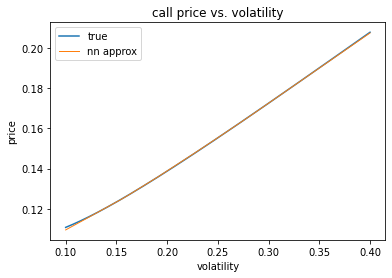

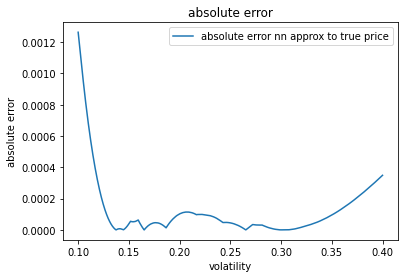

(0.0001238983016091339, 0.0012630115640777095)

In [1551]:
model_multilevel = Multilevel_nn(model_multilevel_list)
test_nn(model_multilevel, x_test, y_test, same_scale = False, visualize = True)

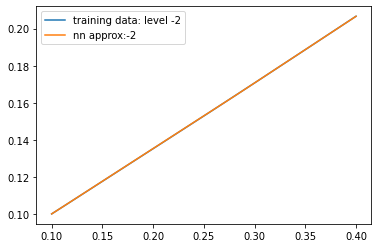

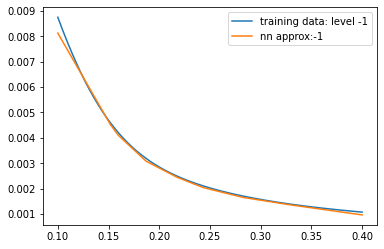

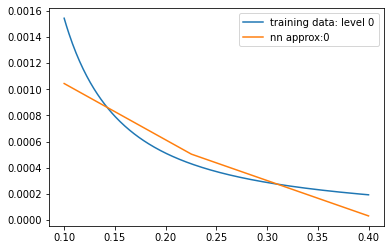

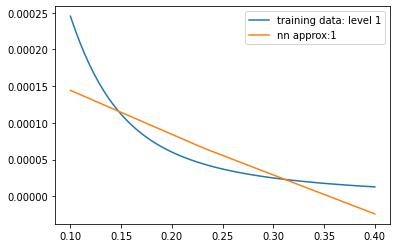

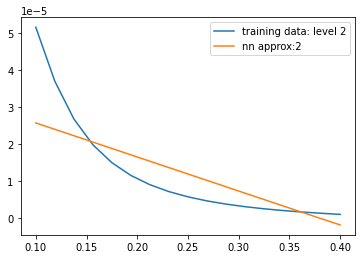

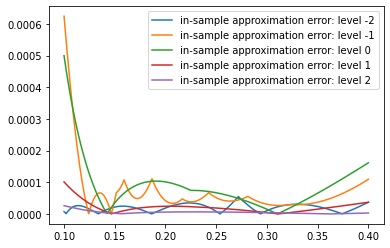

In [1552]:
# for i, l in enumerate(L):
#     x_train, y_train = set_multilevel_train[i]
#     plt.plot(x_train, y_train, label = "input data: level " + str(l))
# plt.legend()
# plt.show()
approx_err_list = []

for i, l in enumerate(L):
    model = model_multilevel_list[i]
    x_train, y_train, x_val, y_val = set_multilevel[i]
    x_train = torch.reshape(torch.Tensor(x_train), (len(x_train),1))
    y_nn = model.evaluate_original(x_train)
    y_nn = y_nn.squeeze(dim=1).detach().numpy()
    approx_err_list.append( (x_train, abs(y_train - y_nn)) )

    plt.plot(x_train, y_train, label = "training data: level " + str(l))
    plt.plot(x_train, y_nn, label = "nn approx:" + str(l))
    plt.legend()
    plt.show()
    
for i, l in enumerate(L):
    x_train, abs_err = approx_err_list[i]
    plt.plot(x_train, abs_err, label = "in-sample approximation error: level " + str(l))
plt.legend()
plt.show()


In [445]:
#save the errors
nn_test_errors_l2 = (test_error_l2_standard, test_error_l2_multigrid, test_error_l2_multilevel)
with open("nn_test_errors_l2.pickle", "wb") as f:
    pickle.dump(nn_test_errors_l2, f)
    
# save the NNs 
torch.save(model_standard, "model_standard.pickle")
torch.save(model_multigrid, "model_multigrid.pickle")
torch.save(model_multilevel, "model_multilevel.pickle")
for i,l in enumerate(L): 
    torch.save(model_multilevel_list[i], "model_multilevel_level_ " + str(l) + ".pickle")


/Users/filippo/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Comparison

In [668]:
from math import isclose, sqrt

def error_gen(actual, rounded):
    divisor = sqrt(1.0 if actual < 1.0 else actual)
    return abs(rounded - actual) ** 2 / divisor

def round_to_100(percents):
    if not isclose(sum(percents), 100):
        raise ValueError
    n = len(percents)
    rounded = [int(x) for x in percents]
    up_count = 100 - sum(rounded)
    errors = [(error_gen(percents[i], rounded[i] + 1) - error_gen(percents[i], rounded[i]), i) for i in range(n)]
    rank = sorted(errors)
    for i in range(up_count):
        rounded[rank[i][1]] += 1
    return np.array(rounded)

In [447]:
# load errors
with open("nn_test_errors_l2.pickle", "rb") as f:
    test_error_l2_standard, test_error_l2_multigrid, test_error_l2_multilevel = pickle.load(f)

model_multilevel_list = []
model_standard = torch.load("model_standard.pickle")
model_multigrid = torch.load("model_multigrid.pickle")
model_multilevel = torch.load("model_multilevel.pickle")
for i,l in enumerate(L): 
    model_l = torch.load("model_multilevel_level_ " + str(l) + ".pickle")
    model_multilevel_list.append(model_l)

In [448]:
# min_samples = len(set_multigrid[-1][0])
# scale_to = min_samples - 1 
nbr_sgd_steps_L = num_epochs_L*train_size_L
pct_sgd_steps_L = nbr_sgd_steps / nbr_sgd_steps.sum() * 100
pct_sgd_steps_L = round_to_100(pct_sgd_steps_L)
pct_sgd_spets = int(np.round( num_epochs_standard*len(x_train_standard) * 100 / nbr_sgd_steps_L.sum()))

err_multigrid_comparison = np.empty(0)
err_multilevel_comparison = np.empty(0)
idx_epochs_l = 0 
for i,l in enumerate(L):
    num_epochs_l = num_epochs_L[i]
    idx_epochs_l += num_epochs_l
    pct_sgd_steps_l = pct_sgd_steps_L[i]
    if i == 0:
        err_multigrid = np.array(test_error_l2_multigrid[:idx_epochs_l])
        err_multilevel = np.array(test_error_l2_multilevel[:idx_epochs_l])
    else:
        idx_epochs_lm1 = idx_epochs_l - num_epochs_l
        err_multigrid = np.array(test_error_l2_multigrid[idx_epochs_lm1:idx_epochs_l])
        err_multilevel = np.array(test_error_l2_multilevel[idx_epochs_lm1:idx_epochs_l])
    assert len(err_multigrid) == num_epochs_l and len(err_multilevel) == num_epochs_l
    
    elements_to_remove = len(err_multigrid) % pct_sgd_steps_l
    if elements_to_remove > 0:
        err_multigrid = err_multigrid[:-elements_to_remove]
        err_multilevel = err_multilevel[:-elements_to_remove]
    mean_multigrid = err_multigrid.reshape(pct_sgd_steps_l, len(err_multigrid)//pct_sgd_steps_l).mean(axis=1)
    mean_multilevel = err_multilevel.reshape(pct_sgd_steps_l, len(err_multigrid)//pct_sgd_steps_l).mean(axis=1)
#     mean_multigrid = err_multigrid.reshape(scale_to,int(len(err_multigrid)/scale_to)).mean(axis = 1)
#     mean_multilevel = err_multilevel.reshape(scale_to,int(len(err_multilevel)/scale_to)).mean(axis = 1)
    err_multigrid_comparison = np.append(err_multigrid_comparison, mean_multigrid)
    err_multilevel_comparison = np.append(err_multilevel_comparison, mean_multilevel)

elements_to_remove = len(test_error_l2_standard) % pct_sgd_spets
if elements_to_remove > 0:
    test_error_l2_standard = test_error_l2_standard[:-elements_to_remove]
err_standard_comparison = np.array(test_error_l2_standard).reshape(
    pct_sgd_spets, len(test_error_l2_standard)//pct_sgd_spets).mean(axis = 1)
err_standard_comparison = np.append(err_standard_comparison, [None]*(100-len(err_standard_comparison)))

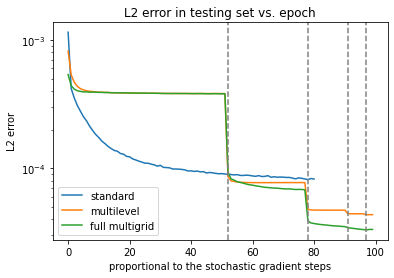

In [464]:
def plot_comparison(err_standard, err_multigrid, err_multilevel, cut_points, err_type):
    fig, ax = plt.subplots()
    plt.plot(err_standard[cut_points:], label = "standard")
    plt.plot(err_multilevel[cut_points:], label = "multilevel")
    plt.plot(err_multigrid[cut_points:], label = "full multigrid")
    for pct_sgd_step in pct_sgd_steps_L[:-1].cumsum():
        plt.axvline(x = pct_sgd_step, color = "grey", linestyle = "--")
    plt.xlabel("proportional to the stochastic gradient steps")
    
    if err_type == "l_2":
        plt.ylabel("L2 error")
        plt.title("L2 error in testing set vs. epoch")
        plt.savefig("plots_neural_pde/l2errror.png")
    elif err_type == "l_inf":
        plt.ylabel("L^infinity error")
        plt.title("L^infinity error in testing set vs. epoch")
    else:
        raise ValueError("No valid error type")
    plt.yscale("log")
    plt.legend()
    plt.show()
plot_comparison(err_standard_comparison, err_multigrid_comparison, err_multilevel_comparison, 0, "l_2")

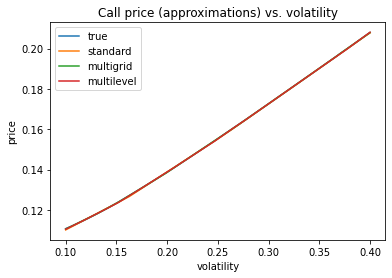

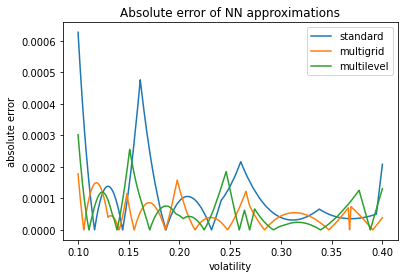

In [465]:
x_test_size = len(x_test)
x_test = torch.reshape(torch.Tensor(x_test), (x_test_size,1))

y_test_standard = model_standard(x_test).squeeze().detach().numpy()
y_test_multigrid = model_multigrid(x_test).squeeze().detach().numpy()
y_test_multilevel = model_multilevel.evaluate(x_test).squeeze().detach().numpy()
plt.plot(x_test, y_test_true, label = "true")
plt.plot(x_test, y_test_standard, label = "standard")
plt.plot(x_test, y_test_multigrid, label = "multigrid")
plt.plot(x_test, y_test_multilevel, label = "multilevel")
plt.xlabel("volatility")
plt.ylabel("price")
plt.title("Call price (approximations) vs. volatility")
plt.legend()
plt.savefig("plots_neural_pde/call_price_approximations_vs_vol.png")
plt.show()

plt.plot(x_test, abs(y_test_standard - y_test_true), label = "standard")
plt.plot(x_test, abs(y_test_multigrid - y_test_true), label = "multigrid")
plt.plot(x_test, abs(y_test_multilevel - y_test_true), label = "multilevel")
plt.title("Absolute error of NN approximations")
plt.xlabel("volatility")
plt.ylabel("absolute error")
plt.legend()
plt.savefig("plots_neural_pde/absolute_error.png")
plt.show()


To Do: 
- plot the number of initial samples (same cost for the generation of the data set) versus the testing accuracy for each approach

**Question:**
- Why does the neural network train much better if I use S0 = 1 instead of S0 = 100 (with respective K, S_max) for generating the training sample?

**Idea:**
- is it worth looking at different grid point discretization instead of reusing the same one? 